<a href="https://colab.research.google.com/github/ShivinM-17/nlp-practices/blob/main/Cipher_decryption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import string
import random
import re
import requests
import os
import textwrap

In [ ]:
# create substitution cipher

# one will act as the key, other as the value
letters1 = list(string.ascii_lowercase)
letters2 = list(string.ascii_lowercase)

true_mapping = {}

# shuffle second set of letters
random.shuffle(letters2)

# populate map
for k,v in zip(letters1, letters2):
  true_mapping[k]=v

In [ ]:
true_mapping

{'a': 'n',
 'b': 'p',
 'c': 'q',
 'd': 'k',
 'e': 'o',
 'f': 'r',
 'g': 'c',
 'h': 's',
 'i': 'w',
 'j': 'd',
 'k': 'e',
 'l': 'g',
 'm': 'u',
 'n': 'y',
 'o': 'v',
 'p': 'a',
 'q': 't',
 'r': 'x',
 's': 'm',
 't': 'h',
 'u': 'z',
 'v': 'f',
 'w': 'i',
 'x': 'l',
 'y': 'j',
 'z': 'b'}

### Cipher Decryption using Markov language model

In [ ]:
## language model

# initial markov matrix
M = np.ones((26,26))

# initial state distribution
pi = np.zeros(26)

In [ ]:
# function to update the Markov Martix
def update_transition(ch1, ch2):
  i = ord(ch1) - 97
  j = ord(ch2) - 97
  M[i,j] += 1

# function to update the initial state distribution
def update_pi(ch):
  i=ord(ch)-97
  pi[i] += 1

In [ ]:
# function to get log-probability of a word/token
def get_word_prob(word):
  #print ("word":,word)
  i = ord(word[0])-97
  logp = np.log(pi[i])

  for ch in word[1:]:
    j = ord(ch) - 97
    logp += np.log(M[i,j]) #update the prob
    i = j #update i

  return logp

In [ ]:
# function to get the probability of a sequence of words
def get_sequence_prob(words):
  # if input is string, split it into a array of tokens
  if type(words) == str:
    words = words.split()

  logp = 0
  for word in words:
    logp += get_word_prob(word)
  return logp

In [ ]:
# create a markov model based on a English dataset

# download the file
if not os.path.exists('moby_dock.txt'):
  print("Downloading moby dick...")
  r = requests.get("https://lazyprogrammer.me/course_files/moby_dick.txt")
  with open('moby_dock.txt', 'w') as f:
    f.write(r.content.decode())

In [ ]:
# regex for replacing non-alpha characters
regex = re.compile('[^a-zA-Z]')

# load in the words
for line in open('moby_dock.txt'):
  line = line.rstrip()

  # there are blank lines in the file
  if line:
    line = regex.sub(' ', line) # replace all non-alpha characters with space

    # split the tokens in the line and lowercase
    tokens = line.lower().split()

    for token in tokens:
      # update the model

      # first letter
      ch0 = token[0]
      update_pi(ch0)

      # other letters
      for ch1 in token[1:]:
        update_transition(ch0,ch1)
        ch0 = ch1

# normalize the probabilities
pi /= pi.sum()
M /= M.sum(axis=1, keepdims=True)

In [ ]:
original_message = """
I then lounged down the street and found, as I expected, that there was a mews
in a lane which runs down by one wall of the garden. I lent the ostlers a hand
in rubbing down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information as I could
desire about Miss Adler, to say nothing of half a dozen other people in the neighbourhood
in whom I was not in the least interested, but whose biographies I was compelled to listen to.
"""

In [ ]:
# make a function to encode the message
def encode_message(msg):
  # downcase
  msg = msg.lower()

  # replace non-alpha characters
  msg = regex.sub(' ', msg)

  # make the encoded message
  coded_msg = []
  for ch in msg:
    coded_ch = ch # this could be just a space too
    if ch in true_mapping:
      coded_ch = true_mapping[ch]
    coded_msg.append(coded_ch)
  return ''.join(coded_msg)

In [ ]:
encoded_message = encode_message(original_message)
encoded_message

' w hsoy gvzycok kviy hso mhxooh nyk rvzyk  nm w olaoqhok  hsnh hsoxo inm n uoim  wy n gnyo iswqs xzym kviy pj vyo ingg vr hso cnxkoy  w goyh hso vmhgoxm n snyk  wy xzppwyc kviy hsowx svxmom  nyk xoqowfok wy olqsnyco hivaoyqo  n cgnmm vr  sngr nyk sngr  hiv rwggm vr msnc hvpnqqv  nyk nm uzqs wyrvxunhwvy nm w qvzgk  komwxo npvzh uwmm nkgox  hv mnj yvhswyc vr sngr n kvboy vhsox aovago wy hso yowcspvzxsvvk  wy isvu w inm yvh wy hso gonmh wyhoxomhok  pzh isvmo pwvcxnaswom w inm qvuaoggok hv gwmhoy hv  '

In [ ]:
# make a map from true_mapping for decoding the message
map_decode = {}
for k,v in true_mapping.items():
  map_decode[v]=k

In [ ]:
# making a function to decode the message
def decode_message(msg, word_map):
  decoded_msg = []
  for ch in msg:
    decoded_ch = ch
    if ch in word_map:
      decoded_ch = word_map[ch]
    decoded_msg.append(decoded_ch)
  return ''.join(decoded_msg)

In [ ]:
decoded_msg = decode_message(encoded_message, map_decode)
decoded_msg

' i then lounged down the street and found  as i expected  that there was a mews  in a lane which runs down by one wall of the garden  i lent the ostlers a hand  in rubbing down their horses  and received in exchange twopence  a glass of  half and half  two fills of shag tobacco  and as much information as i could  desire about miss adler  to say nothing of half a dozen other people in the neighbourhood  in whom i was not in the least interested  but whose biographies i was compelled to listen to  '

### Cipher decryption using Genetic algorithm

In [ ]:
# making the initialization point
dna_pool = []
for _ in range(20):
  dna = list(string.ascii_lowercase)
  random.shuffle(dna)
  dna_pool.append(dna)

In [ ]:
print(*dna_pool, sep='\n')

['p', 'f', 'y', 'b', 't', 'j', 'q', 'c', 'g', 's', 'w', 'a', 'e', 'r', 'v', 'u', 'm', 'x', 'n', 'k', 'h', 'z', 'l', 'o', 'i', 'd']
['z', 'b', 'g', 'c', 'r', 't', 'w', 'u', 'j', 'e', 'q', 's', 'a', 'h', 'x', 'i', 'n', 'v', 'p', 'k', 'd', 'm', 'o', 'l', 'f', 'y']
['a', 'h', 'q', 'k', 'n', 'd', 'x', 'r', 'v', 'o', 's', 't', 'c', 'm', 'p', 'z', 'e', 'b', 'l', 'i', 'y', 'w', 'u', 'g', 'f', 'j']
['w', 't', 'i', 'b', 'q', 'z', 'n', 'm', 'x', 'e', 'p', 'h', 'r', 'f', 'g', 'o', 'a', 'd', 'v', 'y', 'l', 'u', 'c', 'j', 'k', 's']
['e', 'u', 'm', 'a', 'o', 'x', 'd', 'r', 'c', 'y', 'g', 'w', 't', 'z', 'v', 'f', 'l', 'n', 'h', 'j', 'q', 'k', 'p', 'b', 'i', 's']
['l', 'r', 'u', 'w', 'h', 'i', 'v', 'y', 'd', 'n', 's', 'z', 'b', 'j', 'c', 'e', 'o', 'g', 'm', 'q', 'x', 'f', 't', 'a', 'k', 'p']
['r', 'k', 'o', 'm', 'v', 'x', 'b', 'q', 'f', 't', 'c', 'u', 'n', 'g', 'p', 'y', 'z', 'a', 'e', 'w', 'l', 'd', 's', 'h', 'i', 'j']
['k', 'l', 'e', 'b', 'r', 'q', 'u', 'n', 'a', 'p', 'i', 'c', 'y', 'f', 'j', 't', 's

In [ ]:
def evolve_offspring(dna_pool, n_children):
  # make n_children per offspring
  offspring = []

  for dna in dna_pool:
    for _ in range(n_children):
      copy = dna.copy()
      j = np.random.randint(len(copy))
      k = np.random.randint(len(copy))

      # switch
      tmp = copy[j]
      copy[j] = copy[k]
      copy[k] = tmp
      offspring.append(copy)
  return offspring + dna_pool

In [ ]:
print(*evolve_offspring(dna_pool, 5), sep='\n')
print(len(evolve_offspring(dna_pool, 5)))

['p', 'j', 'y', 'b', 't', 'f', 'q', 'c', 'g', 's', 'w', 'a', 'e', 'r', 'v', 'u', 'm', 'x', 'n', 'k', 'h', 'z', 'l', 'o', 'i', 'd']
['p', 'f', 'y', 'b', 't', 's', 'q', 'c', 'g', 'j', 'w', 'a', 'e', 'r', 'v', 'u', 'm', 'x', 'n', 'k', 'h', 'z', 'l', 'o', 'i', 'd']
['p', 'f', 'y', 'b', 't', 'j', 'a', 'c', 'g', 's', 'w', 'q', 'e', 'r', 'v', 'u', 'm', 'x', 'n', 'k', 'h', 'z', 'l', 'o', 'i', 'd']
['p', 'f', 'y', 'b', 't', 'j', 'q', 'r', 'g', 's', 'w', 'a', 'e', 'c', 'v', 'u', 'm', 'x', 'n', 'k', 'h', 'z', 'l', 'o', 'i', 'd']
['p', 'f', 'y', 'b', 't', 'j', 'q', 'c', 'h', 's', 'w', 'a', 'e', 'r', 'v', 'u', 'm', 'x', 'n', 'k', 'g', 'z', 'l', 'o', 'i', 'd']
['z', 'j', 'g', 'c', 'r', 't', 'w', 'u', 'b', 'e', 'q', 's', 'a', 'h', 'x', 'i', 'n', 'v', 'p', 'k', 'd', 'm', 'o', 'l', 'f', 'y']
['z', 'q', 'g', 'c', 'r', 't', 'w', 'u', 'j', 'e', 'b', 's', 'a', 'h', 'x', 'i', 'n', 'v', 'p', 'k', 'd', 'm', 'o', 'l', 'f', 'y']
['q', 'b', 'g', 'c', 'r', 't', 'w', 'u', 'j', 'e', 'z', 's', 'a', 'h', 'x', 'i', 'n

In [ ]:
num_iters = 1000
scores = np.zeros(num_iters)
best_dna = None
best_map = None
best_score = float('-inf')

for i in range(num_iters):
  if i>0:
    # get offspring from the current dna pool
    dna_pool = evolve_offspring(dna_pool, 3)

  # calculate score for each dna
  dna2score = {}
  for dna in dna_pool:
    # populate map
    current_map = {}
    for k,v in zip(letters1, dna):
      current_map[k] = v

    decoded_message = decode_message(encoded_message, current_map)
    score = get_sequence_prob(decoded_message)

    # store it
    # key must be a string
    dna2score[''.join(dna)] = score

    # record the best so far
    if score > best_score:
      best_score = score
      best_map = current_map
      best_dna = dna

  # average score for this generation
  scores[i] = np.mean(list(dna2score.values()))

  # keep the best 5 dna
  # also turn them back into list of single characters
  sorted_dna = sorted(dna2score.items(), key = lambda x:x[1], reverse=True)
  dna_pool = [list(k) for k,v in sorted_dna[:5]]

  if i%100==0:
    print(f"iter: {i}, score: {scores[i]}, best_so_far: {best_score}")

iter: 0, score: -2095.5012347550946, best_so_far: -1887.1846407823928
iter: 100, score: -1319.6240316528845, best_so_far: -1229.7967232801907
iter: 200, score: -1190.9608036259024, best_so_far: -1127.1864661364573
iter: 300, score: -1109.5249238512388, best_so_far: -1010.9256835192423
iter: 400, score: -1025.1903293047396, best_so_far: -943.3736961390512
iter: 500, score: -1034.1159254873157, best_so_far: -941.5300142320273
iter: 600, score: -1025.6425718764478, best_so_far: -941.5300142320273
iter: 700, score: -1006.6305016563416, best_so_far: -941.5300142320273
iter: 800, score: -1010.0005297548636, best_so_far: -941.5300142320273
iter: 900, score: -1057.7386300293215, best_so_far: -941.5300142320273


In [ ]:
# use best score
decoded_message = decode_message(encoded_message, best_map)

print('LL of decoded message: ', get_sequence_prob(decoded_message))
print('LL of true message: ', get_sequence_prob(regex.sub(' ', original_message.lower())))

# which letters are wrong
for true, v in true_mapping.items():
  pred = best_map[v]
  if true != pred:
    print(f"true: {true}, pred: {pred}")

LL of decoded message:  -941.5300142320273
LL of true message:  -933.0312453751817
true: b, pred: f
true: f, pred: y
true: j, pred: z
true: k, pred: j
true: y, pred: b
true: z, pred: k


In [ ]:
print("Decoded message: \n", textwrap.fill(decoded_message, 100))
print("\nOriginal message: \n", original_message)

Decoded message: 
  i then lounged down the street and yound  as i expected  that there was a mews  in a lane which
runs down fb one wall oy the garden  i lent the ostlers a hand  in ruffing down their horses  and
received in exchange twopence  a glass oy  haly and haly  two yills oy shag tofacco  and as much
inyormation as i could  desire afout miss adler  to sab nothing oy haly a doken other people in the
neighfourhood  in whom i was not in the least interested  fut whose fiographies i was compelled to
listen to

Original message: 
 
I then lounged down the street and found, as I expected, that there was a mews 
in a lane which runs down by one wall of the garden. I lent the ostlers a hand 
in rubbing down their horses, and received in exchange twopence, a glass of 
half-and-half, two fills of shag tobacco, and as much information as I could 
desire about Miss Adler, to say nothing of half a dozen other people in the neighbourhood 
in whom I was not in the least interested, but whose

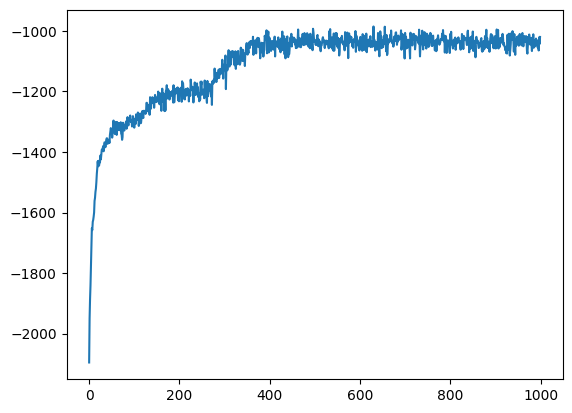

In [ ]:
plt.plot(scores)
plt.show()